In [1]:
import os
import random

import numpy as np
import pandas as pd
import scipy.sparse as sps
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

In [2]:
item_type = pd.read_csv('data/data_ICM_type.csv', usecols = ['item_id', 'feature_id'], dtype={0:int, 1:int}).set_index('item_id')
item_length = pd.read_csv('data/data_ICM_length.csv', usecols = ['item_id', 'data'], dtype={0:int, 1:int}).set_index('item_id')
item_length = item_length.rename(columns={'data': 'length'})
interactions = pd.read_csv('data/interactions_and_impressions.csv', dtype={0:int, 1:int, 2:str, 3:int})
interactions = interactions.rename(columns={'UserID': 'user_id', 'ItemID': 'item_id', 'Data': 'data', 'Impressions': 'impressions'})
views = interactions[interactions["data"] == 0].drop(['data', 'impressions'], axis=1)
details = interactions[interactions["data"] == 1].drop(['data', 'impressions'], axis=1)

In [3]:
views["views_count"] = 1
progress = views.groupby(["user_id", "item_id"], as_index = False)["views_count"].sum()
progress = progress.join(item_length, on="item_id")
progress

,user_id,item_id,views_count,length
0,0,21,3,27.0
1,0,124,1,3.0
2,0,808,1,1.0
3,0,1326,1,3.0
4,0,1995,1,17.0
...,...,...,...,...
1051823,41628,15971,1,1.0
1051824,41628,19992,1,1.0
1051825,41628,20448,1,1.0
1051826,41628,22882,1,60.0


In [4]:
#moda_missing_len = views.groupby(["user_id", "item_id"], as_index = False)["views_count"].sum()
#progress.loc[progress['length'].isna(), 'length'] = 1

In [5]:
#progress["progress"] = (progress["progress"]-progress["progress"].mean())/progress["progress"].std()
progress["progress"] = progress["views_count"]/progress["length"]
progress["progress_finite"] = np.isfinite(progress["progress"].to_numpy())
progress.loc[progress["progress"].isna(), "progress"] = 1.0

In [6]:
URM_all = sps.coo_matrix((progress["progress"].values, (progress["user_id"].values, progress["item_id"].values)))

In [7]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 1596 ( 3.8%) Users that have less than 1 test interactions


In [10]:
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender

recommender = SLIMElasticNetRecommender(URM_train)
recommender.fit()

SLIMElasticNetRecommender: Processed 6262 (25.6%) in 5.00 min. Items per second: 20.87
SLIMElasticNetRecommender: Processed 13871 (56.6%) in 10.00 min. Items per second: 23.12
SLIMElasticNetRecommender: Processed 21573 (88.0%) in 15.00 min. Items per second: 23.97
SLIMElasticNetRecommender: Processed 24507 (100.0%) in 16.27 min. Items per second: 25.10


In [11]:
result_df, _ = evaluator_validation.evaluateRecommender(recommender)
result_df

d:\Developing\RecSys_PoliMi_challenge_2020\Evaluation\metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
d:\Developing\RecSys_PoliMi_challenge_2020\Evaluation\metrics.py:270: RuntimeWarning: invalid value encountered in double_scalars
  ndcg_ = rank_dcg / ideal_dcg


EvaluatorHoldout: Processed 40033 (100.0%) in 26.65 sec. Users per second: 1502


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.017825,0.030434,0.028597,0.008052,0.013612,0.064522,NaN,0.021962,0.142058,0.071792,...,0.961661,0.136611,0.961661,0.003533,6.672382,0.982581,0.008026,0.506106,2.065039,0.465928


In [ ]:
x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = IALSRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 509.88 column/sec. Elapsed time 48.06 sec
EvaluatorHoldout: Processed 38923 (100.0%) in 25.37 sec. Users per second: 1534
ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 506.18 column/sec. Elapsed time 48.42 sec
EvaluatorHoldout: Processed 38923 (100.0%) in 27.38 sec. Users per second: 1422
ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 436.99 column/sec. Elapsed time 56.08 sec
EvaluatorHoldout: Processed 38923 (100.0%) in 32.09 sec. Users per second: 1213
ItemKNNCFRecommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to

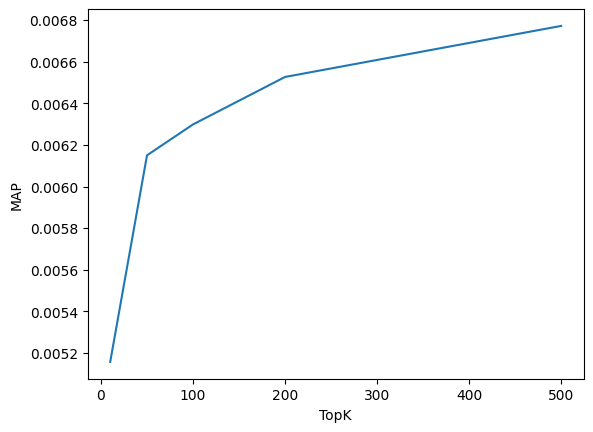

In [ ]:
plt.plot(x_tick, MAP_per_k)
plt.ylabel('MAP')
plt.xlabel('TopK')
plt.show()

In [20]:
recommender = IALSRecommender(URM_all)
recommender.fit(shrink=0.0, topK=750)

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 315.33 column/sec. Elapsed time 1.30 min


In [12]:
target_users = pd.read_csv('Data/data_target_users_test.csv', dtype={0:int})

In [13]:
target_users = pd.read_csv('Data/data_target_users_test.csv', dtype={0:int})["user_id"].values

print("Creating recomendations...")
recomendations = recommender.recommend(
    target_users,
    cutoff = 10
)

Creating recomendations...


In [14]:
from datetime import datetime
out = os.path.join('Output', datetime.now().strftime('%Y_%m_%d_%H_%M_%S') + '.csv')
print("Writing to file...")
with open(out, 'w') as f:
    f.write('user_id,item_list\n')

    for i in range(len(target_users)):
        f.write(str(target_users[i]) + "," + " ".join(str(x) for x in recomendations[i]) + "\n")

Writing to file...
